In [1]:
# !pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q


In [104]:
# summarisaiotn model tutorial code
# referenced from  https://github.com/entbappy/NLP-Projects-Notebooks/blob/master/Text-Summarization-Fine-tuning-Transformers-model.ipynb
from transformers import pipeline, set_seed
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import evaluate 
import nltk
from nltk.tokenize import sent_tokenize
import os
import pandas as pd
import random
from rouge_score import rouge_scorer
from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zacha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [99]:


device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
print(device)

cuda


In [100]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [101]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=12, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [108]:
#load data 
#from https://huggingface.co/datasets/samsum
# dataset_samsum = load_dataset("samsum")
from datasets import load_dataset
dataset_cnn = load_dataset("cnn_dailymail", "3.0.0")
print(dataset_cnn)
print(dataset_cnn["test"][0]["article"])
print("\nHighlights:")
print(dataset_cnn["test"][0]["highlights"])

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for poss

In [109]:

#train and test on a fraction of the whole dataset
import random
total_size_train = len(dataset_cnn["train"])
fraction_train = 0.3 
subset_size_train = int(total_size_train * fraction_train) 
indices_train = random.sample(range(total_size_train), subset_size_train) 
dataset_cnn_train_subset = dataset_cnn["train"].select(indices_train) 

total_size_validation = len(dataset_cnn["validation"])
fraction_validation = 0.3
subset_size_validation = int(total_size_validation * fraction_validation)
indices_validation = random.sample(range(total_size_validation), subset_size_validation)
dataset_cnn_validation_subset = dataset_cnn["validation"].select(indices_validation)

total_size_test = len(dataset_cnn["test"])
fraction_test = 0.3
subset_size_test = int(total_size_test * fraction_test)
indices_test = random.sample(range(total_size_test), subset_size_test)
dataset_cnn_test_subset = dataset_cnn["test"].select(indices_test)

from datasets import DatasetDict
dataset_cnn = DatasetDict({
    "train": dataset_cnn_train_subset,
    "validation": dataset_cnn_validation_subset,
    "test": dataset_cnn_test_subset
})

In [110]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_cnn['test'][0]['article'] )

print(pipe_out)

Token indices sequence length is longer than the specified maximum sequence length for this model (947 > 512). Running this sequence through the model will result in indexing errors


[{'summary_text': "Sam Tomkins has been released by the new Zealand Warriors . the 26-year-old says it is 'not a foregone conclusion' that he will return to the DW . he says he wants to be back in the north of the country around his family ."}]


In [93]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

the ICC officially became the 123rd member of the international criminal court . the court has jurisdiction over alleged crimes committed in the occupied territories . a preliminary examination into the situation in the territories was opened .


In [111]:
rouge_metric = evaluate.load('rouge')

score = calculate_metric_on_test_ds(dataset_cnn['test'], rouge_metric, model_t5, tokenizer, column_text = 'article', column_summary='highlights', batch_size=8)

  1%|          | 5/431 [00:21<30:06,  4.24s/it]


KeyboardInterrupt: 

In [123]:

# ROUGE-L : longest common subsequence (LCS) between model output and reference



rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
# rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

# pd.DataFrame(rouge_dict, index = ['pegasus'])
rouge_dict = dict((rn, score[rn].fmeasure) for rn in rouge_names)

# # Create a pandas DataFrame from the dictionary
# pd.DataFrame(rouge_dict, index = ['t5-small'])

AttributeError: 'numpy.float64' object has no attribute 'fmeasure'

# Histogram

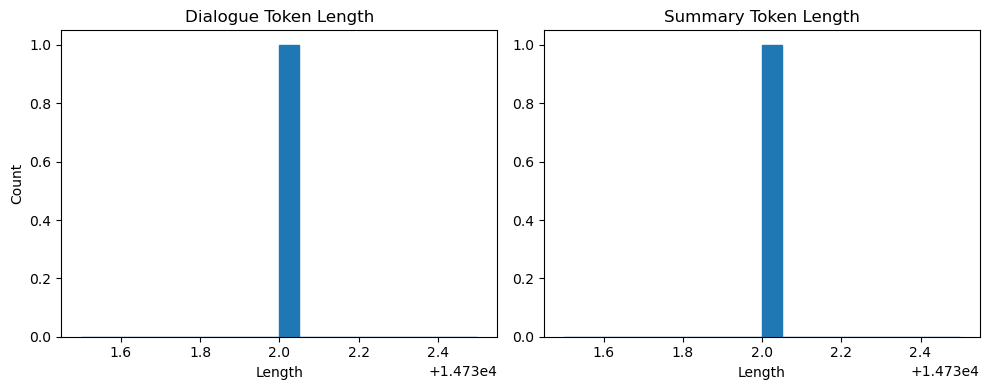

In [19]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [112]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['article'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['highlights'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_cnn_pt = dataset_cnn.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/86133 [00:00<?, ? examples/s]

c:\Users\zacha\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4010 [00:00<?, ? examples/s]

Map:   0%|          | 0/3447 [00:00<?, ? examples/s]

In [113]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_t5)

In [114]:


trainer_args = TrainingArguments(
    output_dir='tm-small-cnn-model', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

In [115]:

trainer = Trainer(model=model_t5, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_cnn_pt["train"], 
                  eval_dataset=dataset_cnn_pt["validation"])

In [116]:
trainer.train()


  0%|          | 0/5383 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 2.4419, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
{'loss': 2.4172, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0}
{'loss': 2.4329, 'learning_rate': 3e-06, 'epoch': 0.01}
{'loss': 2.3875, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.01}
{'loss': 2.4607, 'learning_rate': 5e-06, 'epoch': 0.01}
{'loss': 2.3889, 'learning_rate': 6e-06, 'epoch': 0.01}
{'loss': 2.3738, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.01}
{'loss': 2.3177, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.01}
{'loss': 2.2773, 'learning_rate': 9e-06, 'epoch': 0.02}
{'loss': 2.295, 'learning_rate': 1e-05, 'epoch': 0.02}
{'loss': 2.1588, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.02}
{'loss': 2.2216, 'learning_rate': 1.2e-05, 'epoch': 0.02}
{'loss': 2.1755, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.02}
{'loss': 2.1129, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.03}
{'loss': 2.0835, 'learning_rate': 1.5e-05, 'epoch': 0.03}
{'loss': 2.1827, 'learning

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.7563989162445068, 'eval_runtime': 102.0611, 'eval_samples_per_second': 39.29, 'eval_steps_per_second': 39.29, 'epoch': 0.09}
{'loss': 1.9279, 'learning_rate': 4.989760393200901e-05, 'epoch': 0.09}
{'loss': 1.9292, 'learning_rate': 4.9795207864018024e-05, 'epoch': 0.1}
{'loss': 1.9408, 'learning_rate': 4.969281179602703e-05, 'epoch': 0.1}
{'loss': 1.91, 'learning_rate': 4.9590415728036046e-05, 'epoch': 0.1}
{'loss': 2.0558, 'learning_rate': 4.9488019660045054e-05, 'epoch': 0.1}
{'loss': 1.9357, 'learning_rate': 4.938562359205407e-05, 'epoch': 0.1}
{'loss': 1.9287, 'learning_rate': 4.928322752406308e-05, 'epoch': 0.11}
{'loss': 1.8499, 'learning_rate': 4.918083145607209e-05, 'epoch': 0.11}
{'loss': 2.0038, 'learning_rate': 4.90784353880811e-05, 'epoch': 0.11}
{'loss': 1.8512, 'learning_rate': 4.897603932009011e-05, 'epoch': 0.11}
{'loss': 1.9571, 'learning_rate': 4.887364325209912e-05, 'epoch': 0.11}
{'loss': 1.9789, 'learning_rate': 4.8771247184108134e-05, 'epoch': 0.12}

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.7241308689117432, 'eval_runtime': 97.2518, 'eval_samples_per_second': 41.233, 'eval_steps_per_second': 41.233, 'epoch': 0.19}
{'loss': 1.9618, 'learning_rate': 4.477780053245956e-05, 'epoch': 0.19}
{'loss': 2.0207, 'learning_rate': 4.4675404464468565e-05, 'epoch': 0.19}
{'loss': 2.0427, 'learning_rate': 4.457300839647758e-05, 'epoch': 0.19}
{'loss': 1.9673, 'learning_rate': 4.447061232848659e-05, 'epoch': 0.19}
{'loss': 1.91, 'learning_rate': 4.43682162604956e-05, 'epoch': 0.2}
{'loss': 1.8944, 'learning_rate': 4.426582019250461e-05, 'epoch': 0.2}
{'loss': 1.8908, 'learning_rate': 4.4163424124513617e-05, 'epoch': 0.2}
{'loss': 1.9419, 'learning_rate': 4.406102805652263e-05, 'epoch': 0.2}
{'loss': 1.8819, 'learning_rate': 4.395863198853164e-05, 'epoch': 0.2}
{'loss': 1.9195, 'learning_rate': 4.385623592054065e-05, 'epoch': 0.2}
{'loss': 1.8721, 'learning_rate': 4.375383985254967e-05, 'epoch': 0.21}
{'loss': 1.9897, 'learning_rate': 4.3651443784558675e-05, 'epoch': 0.21}


  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.716221570968628, 'eval_runtime': 97.6191, 'eval_samples_per_second': 41.078, 'eval_steps_per_second': 41.078, 'epoch': 0.28}
{'loss': 1.8766, 'learning_rate': 3.96579971329101e-05, 'epoch': 0.28}
{'loss': 1.8598, 'learning_rate': 3.9555601064919106e-05, 'epoch': 0.28}
{'loss': 1.9032, 'learning_rate': 3.945320499692812e-05, 'epoch': 0.28}
{'loss': 1.8867, 'learning_rate': 3.9350808928937135e-05, 'epoch': 0.29}
{'loss': 2.0072, 'learning_rate': 3.924841286094614e-05, 'epoch': 0.29}
{'loss': 1.9456, 'learning_rate': 3.914601679295516e-05, 'epoch': 0.29}
{'loss': 1.9297, 'learning_rate': 3.9043620724964164e-05, 'epoch': 0.29}
{'loss': 1.8394, 'learning_rate': 3.894122465697317e-05, 'epoch': 0.29}
{'loss': 1.9323, 'learning_rate': 3.8838828588982186e-05, 'epoch': 0.3}
{'loss': 1.8068, 'learning_rate': 3.8736432520991194e-05, 'epoch': 0.3}
{'loss': 1.984, 'learning_rate': 3.863403645300021e-05, 'epoch': 0.3}
{'loss': 1.9096, 'learning_rate': 3.8531640385009216e-05, 'epoch': 

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.7080105543136597, 'eval_runtime': 97.8106, 'eval_samples_per_second': 40.998, 'eval_steps_per_second': 40.998, 'epoch': 0.37}
{'loss': 1.9732, 'learning_rate': 3.453819373336064e-05, 'epoch': 0.37}
{'loss': 1.9733, 'learning_rate': 3.4435797665369654e-05, 'epoch': 0.38}
{'loss': 1.9638, 'learning_rate': 3.433340159737866e-05, 'epoch': 0.38}
{'loss': 1.8653, 'learning_rate': 3.423100552938767e-05, 'epoch': 0.38}
{'loss': 1.834, 'learning_rate': 3.412860946139668e-05, 'epoch': 0.38}
{'loss': 1.8911, 'learning_rate': 3.402621339340569e-05, 'epoch': 0.38}
{'loss': 1.9262, 'learning_rate': 3.3923817325414705e-05, 'epoch': 0.38}
{'loss': 1.9262, 'learning_rate': 3.382142125742372e-05, 'epoch': 0.39}
{'loss': 1.9079, 'learning_rate': 3.371902518943273e-05, 'epoch': 0.39}
{'loss': 1.9991, 'learning_rate': 3.361662912144174e-05, 'epoch': 0.39}
{'loss': 1.8826, 'learning_rate': 3.351423305345075e-05, 'epoch': 0.39}
{'loss': 1.9186, 'learning_rate': 3.341183698545976e-05, 'epoch':

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.7015990018844604, 'eval_runtime': 98.6682, 'eval_samples_per_second': 40.641, 'eval_steps_per_second': 40.641, 'epoch': 0.46}
{'loss': 1.8442, 'learning_rate': 2.9418390333811184e-05, 'epoch': 0.47}
{'loss': 1.854, 'learning_rate': 2.9315994265820195e-05, 'epoch': 0.47}
{'loss': 1.8762, 'learning_rate': 2.9213598197829206e-05, 'epoch': 0.47}
{'loss': 1.8587, 'learning_rate': 2.9111202129838217e-05, 'epoch': 0.47}
{'loss': 1.9454, 'learning_rate': 2.9008806061847228e-05, 'epoch': 0.47}
{'loss': 1.9488, 'learning_rate': 2.890640999385624e-05, 'epoch': 0.48}
{'loss': 1.8788, 'learning_rate': 2.8804013925865246e-05, 'epoch': 0.48}
{'loss': 1.9853, 'learning_rate': 2.8701617857874257e-05, 'epoch': 0.48}
{'loss': 1.8475, 'learning_rate': 2.8599221789883268e-05, 'epoch': 0.48}
{'loss': 1.9578, 'learning_rate': 2.849682572189228e-05, 'epoch': 0.48}
{'loss': 1.9682, 'learning_rate': 2.839442965390129e-05, 'epoch': 0.48}
{'loss': 1.8584, 'learning_rate': 2.8292033585910304e-05, '

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.7023190259933472, 'eval_runtime': 98.0388, 'eval_samples_per_second': 40.902, 'eval_steps_per_second': 40.902, 'epoch': 0.56}
{'loss': 1.9138, 'learning_rate': 2.4298586934261725e-05, 'epoch': 0.56}
{'loss': 1.8274, 'learning_rate': 2.419619086627074e-05, 'epoch': 0.56}
{'loss': 1.8224, 'learning_rate': 2.4093794798279747e-05, 'epoch': 0.56}
{'loss': 1.852, 'learning_rate': 2.3991398730288758e-05, 'epoch': 0.56}
{'loss': 1.9234, 'learning_rate': 2.388900266229777e-05, 'epoch': 0.57}
{'loss': 1.9297, 'learning_rate': 2.378660659430678e-05, 'epoch': 0.57}
{'loss': 1.9299, 'learning_rate': 2.368421052631579e-05, 'epoch': 0.57}
{'loss': 1.8526, 'learning_rate': 2.35818144583248e-05, 'epoch': 0.57}
{'loss': 1.829, 'learning_rate': 2.3479418390333812e-05, 'epoch': 0.57}
{'loss': 1.9219, 'learning_rate': 2.3377022322342823e-05, 'epoch': 0.58}
{'loss': 1.8739, 'learning_rate': 2.3274626254351834e-05, 'epoch': 0.58}
{'loss': 1.8401, 'learning_rate': 2.3172230186360845e-05, 'epoc

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.696682333946228, 'eval_runtime': 97.4449, 'eval_samples_per_second': 41.151, 'eval_steps_per_second': 41.151, 'epoch': 0.65}
{'loss': 1.9088, 'learning_rate': 1.917878353471227e-05, 'epoch': 0.65}
{'loss': 1.8721, 'learning_rate': 1.907638746672128e-05, 'epoch': 0.65}
{'loss': 1.8422, 'learning_rate': 1.897399139873029e-05, 'epoch': 0.66}
{'loss': 1.8409, 'learning_rate': 1.88715953307393e-05, 'epoch': 0.66}
{'loss': 1.825, 'learning_rate': 1.876919926274831e-05, 'epoch': 0.66}
{'loss': 1.8904, 'learning_rate': 1.8666803194757324e-05, 'epoch': 0.66}
{'loss': 1.9143, 'learning_rate': 1.8564407126766335e-05, 'epoch': 0.66}
{'loss': 1.967, 'learning_rate': 1.8462011058775346e-05, 'epoch': 0.67}
{'loss': 1.9502, 'learning_rate': 1.8359614990784353e-05, 'epoch': 0.67}
{'loss': 1.9511, 'learning_rate': 1.8257218922793364e-05, 'epoch': 0.67}
{'loss': 1.8972, 'learning_rate': 1.8154822854802375e-05, 'epoch': 0.67}
{'loss': 1.8656, 'learning_rate': 1.805242678681139e-05, 'epoch'

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.6930780410766602, 'eval_runtime': 97.3547, 'eval_samples_per_second': 41.19, 'eval_steps_per_second': 41.19, 'epoch': 0.74}
{'loss': 1.971, 'learning_rate': 1.4058980135162812e-05, 'epoch': 0.74}
{'loss': 1.8445, 'learning_rate': 1.3956584067171821e-05, 'epoch': 0.75}
{'loss': 1.9354, 'learning_rate': 1.3854187999180832e-05, 'epoch': 0.75}
{'loss': 1.8855, 'learning_rate': 1.3751791931189841e-05, 'epoch': 0.75}
{'loss': 1.8897, 'learning_rate': 1.3649395863198855e-05, 'epoch': 0.75}
{'loss': 1.8426, 'learning_rate': 1.3546999795207865e-05, 'epoch': 0.75}
{'loss': 1.7944, 'learning_rate': 1.3444603727216876e-05, 'epoch': 0.76}
{'loss': 1.8772, 'learning_rate': 1.3342207659225887e-05, 'epoch': 0.76}
{'loss': 1.84, 'learning_rate': 1.3239811591234896e-05, 'epoch': 0.76}
{'loss': 1.7546, 'learning_rate': 1.313741552324391e-05, 'epoch': 0.76}
{'loss': 1.8296, 'learning_rate': 1.303501945525292e-05, 'epoch': 0.76}
{'loss': 1.9334, 'learning_rate': 1.293262338726193e-05, 'epoc

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.6920325756072998, 'eval_runtime': 97.7342, 'eval_samples_per_second': 41.03, 'eval_steps_per_second': 41.03, 'epoch': 0.84}
{'loss': 1.9414, 'learning_rate': 8.939176735613353e-06, 'epoch': 0.84}
{'loss': 1.8397, 'learning_rate': 8.836780667622365e-06, 'epoch': 0.84}
{'loss': 1.8386, 'learning_rate': 8.734384599631374e-06, 'epoch': 0.84}
{'loss': 1.7489, 'learning_rate': 8.631988531640385e-06, 'epoch': 0.84}
{'loss': 1.8834, 'learning_rate': 8.529592463649396e-06, 'epoch': 0.85}
{'loss': 1.9265, 'learning_rate': 8.427196395658407e-06, 'epoch': 0.85}
{'loss': 1.8349, 'learning_rate': 8.324800327667418e-06, 'epoch': 0.85}
{'loss': 1.9137, 'learning_rate': 8.22240425967643e-06, 'epoch': 0.85}
{'loss': 1.8434, 'learning_rate': 8.12000819168544e-06, 'epoch': 0.85}
{'loss': 1.9219, 'learning_rate': 8.01761212369445e-06, 'epoch': 0.85}
{'loss': 1.9071, 'learning_rate': 7.915216055703462e-06, 'epoch': 0.86}
{'loss': 1.8311, 'learning_rate': 7.812819987712471e-06, 'epoch': 0.86}

  0%|          | 0/4010 [00:00<?, ?it/s]

{'eval_loss': 1.6917119026184082, 'eval_runtime': 96.9037, 'eval_samples_per_second': 41.381, 'eval_steps_per_second': 41.381, 'epoch': 0.93}
{'loss': 1.8251, 'learning_rate': 3.819373336063895e-06, 'epoch': 0.93}
{'loss': 1.8762, 'learning_rate': 3.716977268072906e-06, 'epoch': 0.93}
{'loss': 1.8596, 'learning_rate': 3.614581200081917e-06, 'epoch': 0.93}
{'loss': 1.9407, 'learning_rate': 3.5121851320909276e-06, 'epoch': 0.94}
{'loss': 1.8933, 'learning_rate': 3.4097890640999385e-06, 'epoch': 0.94}
{'loss': 1.873, 'learning_rate': 3.3073929961089495e-06, 'epoch': 0.94}
{'loss': 1.8434, 'learning_rate': 3.2049969281179604e-06, 'epoch': 0.94}
{'loss': 1.8109, 'learning_rate': 3.1026008601269714e-06, 'epoch': 0.94}
{'loss': 1.937, 'learning_rate': 3.000204792135982e-06, 'epoch': 0.95}
{'loss': 1.9031, 'learning_rate': 2.897808724144993e-06, 'epoch': 0.95}
{'loss': 2.0348, 'learning_rate': 2.795412656154004e-06, 'epoch': 0.95}
{'loss': 1.8431, 'learning_rate': 2.693016588163015e-06, 'epoch

TrainOutput(global_step=5383, training_loss=1.9143682458953035, metrics={'train_runtime': 8407.6722, 'train_samples_per_second': 10.245, 'train_steps_per_second': 0.64, 'train_loss': 1.9143682458953035, 'epoch': 1.0})

In [117]:
## Save model
model_t5.save_pretrained("tm-small-cnn-model")

In [118]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\spiece.model',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

In [119]:
import os
summaristion_model_dir = os.path.join(os.getcwd(), "tm-small-samsum-model")
sum_tokeniser_model_dir = os.path.join(os.getcwd(), "tokenizer")


summarization_model = AutoModelForSeq2SeqLM.from_pretrained(summaristion_model_dir)
summarization_model = summarization_model.to(device)
tokenizer_model = AutoTokenizer.from_pretrained(sum_tokeniser_model_dir)




In [121]:
# evaluate the model using rougue metrics
#
# score = calculate_metric_on_test_ds(
#     dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
# )

# rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

# pd.DataFrame(rouge_dict, index = [f'pegasus'] )
# Evaluate the model using ROUGE metrics
score = calculate_metric_on_test_ds(
    dataset_cnn['test'], rouge_metric, summarization_model, tokenizer_model, batch_size = 2, column_text = 'article', column_summary = 'highlights'
)


100%|██████████| 1724/1724 [42:40<00:00,  1.49s/it]


In [124]:

# ROUGE-1:  measures the overlap of single words, ROUGE-2 (bigram) measures the overlap of two-word sequences
print(score)

{'rouge1': 0.017948837735719987, 'rouge2': 0.0006206465824915189, 'rougeL': 0.01768990032634711, 'rougeLsum': 0.017896323722434014}


In [122]:

pd.DataFrame(rouge_dict, index = ['t5 small'] )

NameError: name 'rouge_dict' is not defined

# Test

In [120]:
dataset_samsum = load_dataset("samsum")

In [45]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [46]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [47]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model=summarization_model,tokenizer=tokenizer_model)

In [35]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. He called her last time she was at the park together. Amanda would rather she text him.


In [38]:
article_text="---------------------------------------------------------------------------KeyboardInterrupt                         Traceback (most recent call last)~\AppData\Local\Temp\ipykernel_5556\1449585784.py in <module>----> 1 score = calculate_metric_on_test_ds(  2     dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary' 3 ) 4  5 rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )    12                         padding=max_length, return_tensors=pt) 13 "

print(pipe(article_text, **gen_kwargs)[0]["summary_text"])

a keyboardInterrupt Traceback (most recent call last) is used to calculate metric_on_test_ds, rouge_metric, trainer.model, tokenizer, batch_size = 2 .
